In [1]:
import torch
from torchvision.models import vgg19
from torchvision.models import VGG19_Weights
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

In [2]:
img_size = 400

def get_image(image_path, img_size):
    image = Image.open(image_path)
    loader  = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])
    image = loader(image).unsqueeze(0)
    image = image.to(torch.float)
    print(image.shape)
    
    return image

# plt.imshow(content_image[0].view(1, 2, 0))
content_image = get_image('/kaggle/input/content-img/background.jpg', img_size)
style_image = get_image('/kaggle/input/style-image/style_image.jpg', img_size)

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


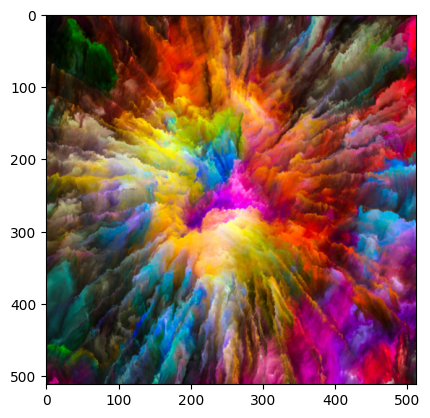

In [3]:
plt.imshow(style_image.permute(0, 2, 3, 1)[0])

In [19]:
image_size = (512, 512)

# Generate random noise for each channel
noise_r = torch.randn(*image_size)
noise_g = torch.randn(*image_size)
noise_b = torch.randn(*image_size)

# Combine the noise into a 3-channel image
noise_rgb = torch.stack([noise_r, noise_g, noise_b], dim=0)

# Scale and shift the noise to the range [0, 1]
noise_rgb = (noise_rgb - noise_rgb.min()) / (noise_rgb.max() - noise_rgb.min())
noise_rgb = noise_rgb.unsqueeze(0)
print(noise_rgb.shape)

noise_rgb.is_leaf

torch.Size([1, 3, 512, 512])


True

In [5]:
class NSTVgg(nn.Module):
    def __init__(self):
        super().__init__()
        self.content_layer = [21]
        self.style_layer = [0, 5, 10, 19, 28]
        self.model = vgg19(weights=VGG19_Weights.DEFAULT).features[:29]
        
    def forward(self, x):
        style_output = list()
        content_output = list()
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if layer_num in self.content_layer:
                content_output.append(x)
                
            elif layer_num in self.style_layer:
                style_output.append(x)
                
        return {'Style_Output':style_output, 'Content_Output':content_output}
    
nst_vgg = NSTVgg()

In [6]:
def content_loss(generated_features, content_features):
    _, filters, h, w = generated_features[0].shape
    
    generated = generated_features[0].view(_, filters, -1)
    content = content_features[0].view(_, filters, -1)
    
    return torch.mean(torch.square(torch.sub(content, generated))) / 2

In [7]:
def gram_matrix(input_features):
    B, filters, h, w = input_features.shape
    
    return torch.mm(input_features.view(filters, -1), input_features.view(filters, -1).transpose(0, 1))

In [8]:
def style_loss(generated_features, style_features):
    B, filters, h, w = generated_features[0].shape
    
    style_loss = 0
    for generated_feature, style_feature in zip(generated_features, style_features):
        generated_gram = gram_matrix(generated_feature)
        style_gram = gram_matrix(style_feature)
        
        loss = torch.sum(torch.square(torch.sub(style_gram, generated_gram))) / (4 * filters**2 * (h*w))
#         loss = torch.mean(torch.square(torch.sub(style_gram, generated_gram)))
#         loss = nn.functional.mse_loss(style_gram, generated_gram)
        style_loss += loss
    
    return style_loss

In [24]:
def compute_loss(generated_features, style_features, content_features, alpha=100, beta=1):
    # calculate style loss
    loss_style = style_loss(generated_features['Style_Output'], style_features['Style_Output'])
    # calculate content loss
    loss_content = content_loss(generated_features['Content_Output'], content_features['Content_Output'])
    # add them up
    total = beta * loss_style + alpha * loss_content
    
    return total, beta * loss_style, alpha * loss_content

In [20]:
device=torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')
print(device)

nst_vgg = NSTVgg().to(device).eval()
content_image = content_image.to(device)
style_image = style_image.to(device)
noise_rgb = noise_rgb.to(device).requires_grad_(True)
print(noise_rgb.is_leaf, noise_rgb.requires_grad)


epoch = 1000
lr = 0.004

optimizer = torch.optim.Adam([noise_rgb], lr=lr)

cuda
True True


In [40]:
total_loss = 0
for e in range(17000, 20000):
    # get output from noise image
    noise_features = nst_vgg(noise_rgb)
    # get output from content image
    content_features = nst_vgg(content_image)
    # get output from style image
    style_features = nst_vgg(style_image)
    
    
    # compute total loss
#     loss = style_loss(noise_features['Style_Output'], style_features['Style_Output'])
    total_loss, loss_style, loss_content = compute_loss(noise_features, style_features, content_features)
#     loss_content = content_loss(noise_features['Content_Output'], content_features['Content_Output'])
#     loss_style = style_loss(noise_features['Style_Output'], style_features['Style_Output'])
#     total_loss = total_loss + loss_content + loss_style
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if e % 100 == 0:
        print(f'Epoch {e} Content Loss: {loss_content} + Style Loss: {loss_style} == {total_loss} ')

Epoch 17000 Content Loss: 34.17609405517578 + Style Loss: 10.051569938659668 == 44.227664947509766 
Epoch 17100 Content Loss: 37.45607376098633 + Style Loss: 15.738855361938477 == 53.19493103027344 
Epoch 17200 Content Loss: 34.22440719604492 + Style Loss: 10.149785041809082 == 44.37419128417969 
Epoch 17300 Content Loss: 34.3048210144043 + Style Loss: 10.393646240234375 == 44.69846725463867 
Epoch 17400 Content Loss: 34.23943328857422 + Style Loss: 10.13442325592041 == 44.37385559082031 
Epoch 17500 Content Loss: 35.85728454589844 + Style Loss: 12.52688980102539 == 48.38417434692383 
Epoch 17600 Content Loss: 33.97280502319336 + Style Loss: 10.117935180664062 == 44.09074020385742 
Epoch 17700 Content Loss: 34.05544662475586 + Style Loss: 10.834250450134277 == 44.88969802856445 
Epoch 17800 Content Loss: 33.48497772216797 + Style Loss: 10.812698364257812 == 44.29767608642578 
Epoch 18100 Content Loss: 33.81896209716797 + Style Loss: 10.00628662109375 == 43.82524871826172 
Epoch 18200 C

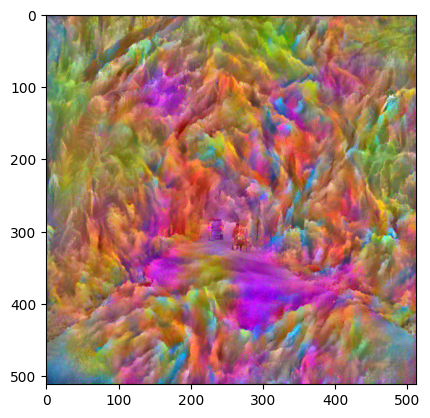

In [41]:
plt.imshow(noise_rgb.permute(0, 2, 3, 1)[0].cpu().detach().numpy())

In [ ]:
vgg_model.features